# Data preprocessing and trajectory analysis

In [1]:
library(data.table) # Fread
library(dplyr)
library(geosphere) # Calculate vehicle distance
library(lubridate)# Date column extraction
library(robfilter)# Smooth the data
library(ggplot2) # Plot
library(ggpubr) # Combine different plots
library(ggmap) # plot points on the map

Warning message:
"package 'data.table' was built under R version 3.6.3"
Warning message:
"package 'dplyr' was built under R version 3.6.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:data.table':

    between, first, last


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'geosphere' was built under R version 3.6.3"

Attaching package: 'lubridate'


The following objects are masked from 'package:data.table':

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following object is masked from 'package:base':

    date


Warning message:
"package 'robfilter' was built under R version 3.6.3"
Loading required package: robustbase

Warning message:
"package 'robustbase' was built under R version 3.6.3"
Loading required package: MASS

Warning message:
"package 'MASS' was built 

In [238]:
library(RColorBrewer)

In [2]:
# adjust the R limit
memory.limit(size=249200)

[1] 249200

## Input location data

In [2]:
# Read data from folder
# Suggestion: Just do one year at one time. One year's table has 94363502 rows(green)
YEARLIST = c('19')
MONTHlIST = c("04") # FOR FULL TABLE
DISTANCE_FILEPATH = "../../data/raw/vehicle-location/"

In [3]:
# Add different time scale columns
add_dd_mm_yy_cols = function(df) {
    df$day = day(df$trxtime)
    df$month = month(df$trxtime)
    df$year = year(df$trxtime)
    return(df)
}
# Read light rail location raw data
get_light_rail_trajectories = function(year, month){
    assign("dg", fread(paste(DISTANCE_FILEPATH, paste("lightrail", "trajectories", month, year, ".csv", sep = "-", collapse = ""), sep="")))
    dg = add_dd_mm_yy_cols(dg)
    return(dg)
}
# Read heavy rail location raw data
get_heavy_rail_trajectories = function(year, month){
    assign("dh", fread(paste(DISTANCE_FILEPATH, paste("heavyrail", "trajectories", month, year, ".csv", sep = "-", collapse = ""), sep="")))
    dh = add_dd_mm_yy_cols(dh)
    return(dh)
}

In [4]:
# Get the raw table
df_lightrail = get_light_rail_trajectories(YEARLIST,MONTHlIST)
df_heavyrail = get_heavy_rail_trajectories(YEARLIST,MONTHlIST)

In [5]:
# Subset table by a given day
get_day_trajectories = function(df, dayid){
    day_df = df[day == dayid, .SD, keyby = .(trainid, vehicleid, routeid) ]
    print(paste("Number of observations", nrow(day_df), "on day", dayid ))
    return(day_df)
}
# Create trajectory index table 
get_unique_trajectory_indices = function(day_df) {
    trajectory_index_df = unique(day_df[, .(trainid, vehicleid, routeid, car1, car2, car3)])
    print(paste("Number of unique trajectories extracted: ", dim(trajectory_index_df)[1]))
    return(trajectory_index_df)
}

# Subset the raw table by unique index
extract_unique_trajectory = function(day_df, traj_index_df, index){
    day_df[["car2"]][is.na(day_df[["car2"]])] <- 9999999
    day_df[["car3"]][is.na(day_df[["car3"]])] <- 9999999
    traj_index_df[["car2"]][is.na(traj_index_df[["car2"]])] <- 9999999
    traj_index_df[["car3"]][is.na(traj_index_df[["car3"]])] <- 9999999
    trajectory = day_df[trainid == traj_index_df[index, 1][[1]] & 
                        vehicleid == traj_index_df[index, 2][[1]] &
                        routeid == traj_index_df[index, 3][[1]] &
                        car1 == traj_index_df[index, 4][[1]] &
                        car2 == traj_index_df[index, 5][[1]] &
                        car3 == traj_index_df[index, 6][[1]],][order(trxtime)]
    clean_trajectory = trajectory[, .SD[1], by = trxtime] # takes first observation of multiple with same time
    clean_trajectory[["car2"]][clean_trajectory[["car2"]] == 9999999] = NA
    clean_trajectory[["car3"]][clean_trajectory[["car3"]] == 9999999] = NA
    # transfer trxtime to timestamp
    options(tz = "America/New_York")
    clean_trajectory$time = as.POSIXct(clean_trajectory$trxtime,tz = getOption("tz"))
    return (clean_trajectory)
}

In [6]:
# generate the specified trajectory table
light_subset = function(df,day,index){
    day_df = get_day_trajectories(df, day)
    trajectory_index_df = get_unique_trajectory_indices(day_df)
    clean_trajectory = extract_unique_trajectory(day_df, trajectory_index_df, index)
    return(clean_trajectory)
}

In [7]:
df_test = light_subset(df_lightrail,1,3)

[1] "Number of observations 313823 on day 1"
[1] "Number of unique trajectories extracted:  1208"


In [8]:
df_test_3 = light_subset(df_lightrail,2,8)

[1] "Number of observations 259529 on day 2"
[1] "Number of unique trajectories extracted:  1438"


In [11]:
df_test_3 

trxtime,trainid,vehicleid,routeid,counter,lineid,lat,lon,servicetypeid,sourceid,...,car3,speed,heading,rcvtime,lastavi,inserted,day,month,year,time
<chr>,<int>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,...,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>,<int>,<dbl>,<dbl>,<dttm>
2019-04-02 18:02:10,10004,3600,853,187219,4,42.35301,-71.06454,1,0,...,NA,NA,NA,2019-04-02 18:02:28,73,2019-04-19 15:25:58,2,4,2019,2019-04-02 18:02:10
2019-04-02 18:03:04,10004,3600,853,187350,4,42.35554,-71.06322,1,0,...,NA,NA,NA,2019-04-02 18:03:07,84,2019-04-19 15:25:58,2,4,2019,2019-04-02 18:03:04
2019-04-02 18:04:23,10004,3600,853,187580,4,42.35621,-71.06257,1,0,...,NA,NA,NA,2019-04-02 18:04:32,85,2019-04-19 15:25:58,2,4,2019,2019-04-02 18:04:23
2019-04-02 18:05:14,10004,3600,853,187934,4,42.35625,-71.06264,1,0,...,NA,NA,NA,2019-04-02 18:05:21,75,2019-04-19 15:25:58,2,4,2019,2019-04-02 18:05:14
2019-04-02 18:06:33,10004,3600,853,188252,4,42.35556,-71.06326,1,0,...,NA,NA,NA,2019-04-02 18:06:42,74,2019-04-19 15:25:58,2,4,2019,2019-04-02 18:06:33
2019-04-02 18:07:36,10004,3600,853,188504,4,42.35356,-71.06432,1,0,...,NA,NA,NA,2019-04-02 18:07:40,83,2019-04-19 15:25:58,2,4,2019,2019-04-02 18:07:36
2019-04-02 18:08:18,10004,3600,853,188666,4,42.35305,-71.06457,1,0,...,NA,NA,NA,2019-04-02 18:08:22,93,2019-04-19 15:25:58,2,4,2019,2019-04-02 18:08:18
2019-04-02 18:09:41,10004,3600,853,189003,4,42.35188,-71.07085,1,0,...,NA,NA,NA,2019-04-02 18:09:45,82,2019-04-19 15:25:58,2,4,2019,2019-04-02 18:09:41
2019-04-02 18:10:23,10004,3600,853,189162,4,42.35164,-71.07172,1,0,...,NA,NA,NA,2019-04-02 18:10:26,92,2019-04-19 15:25:58,2,4,2019,2019-04-02 18:10:23


In [9]:
df_test_2 = light_subset(df_lightrail,2,7)

[1] "Number of observations 259529 on day 2"
[1] "Number of unique trajectories extracted:  1438"


In [10]:
df_test_2

trxtime,trainid,vehicleid,routeid,counter,lineid,lat,lon,servicetypeid,sourceid,...,car3,speed,heading,rcvtime,lastavi,inserted,day,month,year,time
<chr>,<int>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,...,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>,<int>,<dbl>,<dbl>,<dttm>
2019-04-02 08:11:49,10004,3600,852,62364,4,42.33596,-71.24962,1,1,...,NA,28.11,123.68,2019-04-02 08:11:50,34,2019-04-19 15:25:58,2,4,2019,2019-04-02 08:11:49
2019-04-02 08:11:55,10004,3600,852,62386,4,42.33567,-71.24901,1,1,...,NA,32.56,123.76,2019-04-02 08:11:55,34,2019-04-19 15:25:58,2,4,2019,2019-04-02 08:11:55
2019-04-02 08:11:57,10004,3600,852,62393,4,42.33535,-71.24840,1,1,...,NA,33.19,123.92,2019-04-02 08:11:58,34,2019-04-19 15:25:58,2,4,2019,2019-04-02 08:11:57
2019-04-02 08:12:01,10004,3600,852,62406,4,42.33506,-71.24777,1,1,...,NA,33.50,124.01,2019-04-02 08:12:01,34,2019-04-19 15:25:58,2,4,2019,2019-04-02 08:12:01
2019-04-02 08:12:07,10004,3600,852,62426,4,42.33475,-71.24716,1,1,...,NA,33.55,123.87,2019-04-02 08:12:07,34,2019-04-19 15:25:58,2,4,2019,2019-04-02 08:12:07
2019-04-02 08:12:13,10004,3600,852,62455,4,42.33411,-71.24592,1,1,...,NA,33.87,124.25,2019-04-02 08:12:13,34,2019-04-19 15:25:58,2,4,2019,2019-04-02 08:12:13
2019-04-02 08:12:15,10004,3600,852,62469,4,42.33382,-71.24534,1,1,...,NA,33.35,123.37,2019-04-02 08:12:15,34,2019-04-19 15:25:58,2,4,2019,2019-04-02 08:12:15
2019-04-02 08:12:19,10004,3600,852,62499,4,42.33348,-71.24470,1,1,...,NA,27.92,124.43,2019-04-02 08:12:19,34,2019-04-19 15:25:58,2,4,2019,2019-04-02 08:12:19
2019-04-02 08:12:25,10004,3600,852,62530,4,42.33322,-71.24409,1,1,...,NA,13.65,123.85,2019-04-02 08:12:25,34,2019-04-19 15:25:58,2,4,2019,2019-04-02 08:12:25


In [ ]:
compute_day_trajectories = function(month_df, dd) {
    df_dd = get_day_trajectories(month_df, dd)
    traj_indices_dd = get_unique_trajectory_indices(df_dd)
    print(head(traj_indices_dd))
    num_traj = nrow(traj_indices_dd)
    for (tt in seq(num_traj)[1:5] ) { # ideally this should be for the whole sequence
        traj = extract_unique_trajectory(df_dd, traj_indices_dd, tt)
        traj$trajid = tt # add a new column
        traj %<>% preprocess_data() %>% compute_distance() %>% compute_speed_acceleration() 
        if (tt==1) {
            processed_traj_df = traj
        } else {
            processed_traj_df = rbind(processed_traj_df, traj)
        }
    }
    return (processed_traj_df)
}


In [182]:
case_1 = function(clean_trajectory){
    clean_trajectory = compute_time_interval(clean_trajectory)
    clean_trajectory = compute_distance(clean_trajectory)
    clean_trajectory = compute_speed_acceleration(clean_trajectory)
    clean_trajectory = compute_cumulative_time_distance(clean_trajectory)
    trajectory_plot(clean_trajectory)
    return(clean_trajectory)
    }

In [208]:
case_2 = function(clean_trajectory,w){
     clean_trajectory = compute_time_interval(clean_trajectory)
     clean_trajectory = compute_distance(clean_trajectory) 
     filter = robreg.filter(clean_trajectory$dist_meters, width = w, online = FALSE, method= "MED")
     clean_trajectory$dist_meters = filter$level$MED
     clean_trajectory = compute_speed_acceleration(clean_trajectory)
     clean_trajectory = compute_cumulative_time_distance(clean_trajectory)
     trajectory_plot(clean_trajectory)
     return(clean_trajectory)
}

In [259]:
case_3 = function(clean_trajectory){
    clean_trajectory = data.table(clean_trajectory)
    clean_trajectory = compute_time_interval(clean_trajectory)
    clean_trajectory = clean_trajectory[interval_seconds > 1]
    clean_trajectory = compute_time_interval(clean_trajectory)
    clean_trajectory = compute_distance(clean_trajectory)
    clean_trajectory = compute_speed_acceleration(clean_trajectory)
    clean_trajectory = compute_cumulative_time_distance(clean_trajectory)
    trajectory_plot(clean_trajectory)
    return(clean_trajectory)
    
}

In [280]:
case_4 = function(clean_trajectory,w){
    clean_trajectory = data.table(clean_trajectory)
    clean_trajectory = compute_time_interval(clean_trajectory)
    clean_trajectory = clean_trajectory[interval_seconds > 1]
    clean_trajectory = compute_time_interval(clean_trajectory)
    clean_trajectory = compute_distance(clean_trajectory)
    filter = robreg.filter(clean_trajectory$dist_meters, width = w, online = FALSE, method= "MED")
    clean_trajectory$dist_meters = filter$level$MED
    clean_trajectory = compute_speed_acceleration(clean_trajectory)
    clean_trajectory = compute_cumulative_time_distance(clean_trajectory)
    trajectory_plot(clean_trajectory)
    return(clean_trajectory)
}

In [275]:
case_3_test_3 = case_3(df_test_3)

                  time month day          variable      value
1: 2019-04-02 18:03:04     4   2 Distance (meters)         NA
2: 2019-04-02 18:04:23     4   2 Distance (meters)  90.994022
3: 2019-04-02 18:05:14     4   2 Distance (meters)   7.488069
4: 2019-04-02 18:06:33     4   2 Distance (meters)  92.387009
5: 2019-04-02 18:07:36     4   2 Distance (meters) 238.438312
6: 2019-04-02 18:08:18     4   2 Distance (meters)  60.923547
[1] "Line: Green line ; Trainid: 10004 ; Vehicleid:   3600 ; Car1: 3600 ; Car2: 3855 ; Car3: NA ; Date: 4-2"


Warning message:
"Removed 1 row(s) containing missing values (geom_path)."
Warning message:
"Removed 1 rows containing missing values (geom_text)."
file saved to ../../figures/case3_3.png



In [281]:
case_4_test_3 = case_4(df_test_3,9)

1 out of 202 time series values in clean_trajectory$dist_meters are missing. 
                  time month day          variable    value
1: 2019-04-02 18:03:04     4   2 Distance (meters) 91.69052
2: 2019-04-02 18:04:23     4   2 Distance (meters) 91.69052
3: 2019-04-02 18:05:14     4   2 Distance (meters) 91.69052
4: 2019-04-02 18:06:33     4   2 Distance (meters) 91.69052
5: 2019-04-02 18:07:36     4   2 Distance (meters) 91.69052
6: 2019-04-02 18:08:18     4   2 Distance (meters) 90.99402
[1] "Line: Green line ; Trainid: 10004 ; Vehicleid:   3600 ; Car1: 3600 ; Car2: 3855 ; Car3: NA ; Date: 4-2"


Warning message:
"Removed 1 rows containing missing values (geom_text)."
file saved to ../../figures/case4_3.png



In [251]:
case_2_test_2 = case_2(df_test_2,9)

1 out of 1049 time series values in clean_trajectory$dist_meters are missing. 
                  time month day          variable    value
1: 2019-04-02 08:11:49     4   2 Distance (meters) 61.08704
2: 2019-04-02 08:11:55     4   2 Distance (meters) 61.08704
3: 2019-04-02 08:11:57     4   2 Distance (meters) 61.08704
4: 2019-04-02 08:12:01     4   2 Distance (meters) 61.08704
5: 2019-04-02 08:12:07     4   2 Distance (meters) 61.08704
6: 2019-04-02 08:12:13     4   2 Distance (meters) 61.18063
[1] "Line: Green line ; Trainid: 10004 ; Vehicleid:   3600 ; Car1: 3600 ; Car2: 3855 ; Car3: NA ; Date: 4-2"


Warning message:
"Removed 1 rows containing missing values (geom_text)."
file saved to ../../figures/case2_2.png



In [262]:
case_3_test_2 = case_3(df_test_2)

                  time month day          variable     value
1: 2019-04-02 08:11:55     4   2 Distance (meters)        NA
2: 2019-04-02 08:11:57     4   2 Distance (meters)  61.86077
3: 2019-04-02 08:12:01     4   2 Distance (meters)  60.99345
4: 2019-04-02 08:12:07     4   2 Distance (meters)  61.18063
5: 2019-04-02 08:12:13     4   2 Distance (meters) 124.22606
6: 2019-04-02 08:12:15     4   2 Distance (meters)  57.18007
[1] "Line: Green line ; Trainid: 10004 ; Vehicleid:   3600 ; Car1: 3600 ; Car2: 3855 ; Car3: NA ; Date: 4-2"


Warning message:
"Removed 1 row(s) containing missing values (geom_path)."
Warning message:
"Removed 1 rows containing missing values (geom_text)."
file saved to ../../figures/case3_2.png



In [264]:
case_4_test_2 = case_4(df_test_2,10)

1 out of 1018 time series values in clean_trajectory$dist_meters are missing. 
                  time month day          variable    value
1: 2019-04-02 08:11:55     4   2 Distance (meters) 61.86077
2: 2019-04-02 08:11:57     4   2 Distance (meters) 61.86077
3: 2019-04-02 08:12:01     4   2 Distance (meters) 61.86077
4: 2019-04-02 08:12:07     4   2 Distance (meters) 61.86077
5: 2019-04-02 08:12:13     4   2 Distance (meters) 61.86077
6: 2019-04-02 08:12:15     4   2 Distance (meters) 61.86077
[1] "Line: Green line ; Trainid: 10004 ; Vehicleid:   3600 ; Car1: 3600 ; Car2: 3855 ; Car3: NA ; Date: 4-2"


Warning message:
"Removed 1 rows containing missing values (geom_text)."
file saved to ../../figures/case4_2.png



In [195]:
case_1_test = case_1(df_test)

                  time month day          variable     value
1: 2019-04-01 06:36:00     4   1 Distance (meters)        NA
2: 2019-04-01 06:36:06     4   1 Distance (meters) 121.29373
3: 2019-04-01 06:36:12     4   1 Distance (meters)  61.86077
4: 2019-04-01 06:36:13     4   1 Distance (meters)  60.99345
5: 2019-04-01 06:36:18     4   1 Distance (meters)  61.18063
6: 2019-04-01 06:36:24     4   1 Distance (meters)  62.58200
[1] "Line: Green line ; Trainid: 10001 ; Vehicleid:   3699 ; Car1: 3699 ; Car2: 3856 ; Car3: NA ; Date: 4-1"


Warning message:
"Removed 1 row(s) containing missing values (geom_path)."
Warning message:
"Removed 1 rows containing missing values (geom_text)."
file saved to ../../figures/case1.png



In [213]:
case_3_test = case_3(df_test)

                  time month day          variable     value
1: 2019-04-01 06:36:06     4   1 Distance (meters)        NA
2: 2019-04-01 06:36:12     4   1 Distance (meters)  61.86077
3: 2019-04-01 06:36:18     4   1 Distance (meters) 122.15617
4: 2019-04-01 06:36:24     4   1 Distance (meters)  62.58200
5: 2019-04-01 06:36:36     4   1 Distance (meters) 118.82783
6: 2019-04-01 06:36:43     4   1 Distance (meters) 123.31356
[1] "Line: Green line ; Trainid: 10001 ; Vehicleid:   3699 ; Car1: 3699 ; Car2: 3856 ; Car3: NA ; Date: 4-1"


Warning message:
"Removed 1 row(s) containing missing values (geom_path)."
Warning message:
"Removed 1 rows containing missing values (geom_text)."
file saved to ../../figures/case3.png



In [209]:
case_2_test = case_2(df_test,9)

1 out of 200 time series values in clean_trajectory$dist_meters are missing. 
                  time month day          variable    value
1: 2019-04-01 06:36:00     4   1 Distance (meters) 61.75429
2: 2019-04-01 06:36:06     4   1 Distance (meters) 61.75429
3: 2019-04-01 06:36:12     4   1 Distance (meters) 61.75429
4: 2019-04-01 06:36:13     4   1 Distance (meters) 61.75429
5: 2019-04-01 06:36:18     4   1 Distance (meters) 61.75429
6: 2019-04-01 06:36:24     4   1 Distance (meters) 61.64781
[1] "Line: Green line ; Trainid: 10001 ; Vehicleid:   3699 ; Car1: 3699 ; Car2: 3856 ; Car3: NA ; Date: 4-1"


Warning message:
"Removed 1 rows containing missing values (geom_text)."
file saved to ../../figures/case2.png



In [225]:
case_4_test = case_4(df_test,10)

1 out of 178 time series values in clean_trajectory$dist_meters are missing. 
                  time month day          variable    value
1: 2019-04-01 06:36:06     4   1 Distance (meters) 72.00499
2: 2019-04-01 06:36:12     4   1 Distance (meters) 72.00499
3: 2019-04-01 06:36:18     4   1 Distance (meters) 72.00499
4: 2019-04-01 06:36:24     4   1 Distance (meters) 72.00499
5: 2019-04-01 06:36:36     4   1 Distance (meters) 72.00499
6: 2019-04-01 06:36:43     4   1 Distance (meters) 72.00499
[1] "Line: Green line ; Trainid: 10001 ; Vehicleid:   3699 ; Car1: 3699 ; Car2: 3856 ; Car3: NA ; Date: 4-1"


Warning message:
"Removed 1 rows containing missing values (geom_text)."
file saved to ../../figures/case4.png



# Function used for trajectory investigation

In [277]:
# plot each trajectory
trajectory_plot = function(df){
    clean_trajectory_melt = melt(df, id.vars = c("time","month","day") ,
                                 measure.vars = c("dist_meters","cumdist_km","interval_seconds",
                                                  "cumtime_hrs","speed_kph","accel_mps2"))
    # Name new labels for plot
    levels(clean_trajectory_melt$variable) = c("Distance (meters)","Cumulative distance (km)",
                                               "Time interval (s)","Cumulative time (hrs)","Speed (km/h)",
                                               "Acceleration (meters/s^2)")
    print(head(clean_trajectory_melt))
    p_title = title(df)
    # generate the facet plot
    p1 = ggplot(clean_trajectory_melt,aes(x = time,y = value)) + 
    geom_line(colour="darkorange") + 
    theme(strip.text = element_text(size = rel(1)), axis.title.y = element_blank()) + 
    facet_wrap(~variable,ncol = 2 , scales = "free_y") +
    labs(title = p_title, x = "Time") +
    theme(axis.title.x = element_text(size = 20), title= element_text(size = 20))
    # Trajectory map
    # Get map
    ma <- get_stamenmap(bbox = c(left = min(df$lon), bottom = min(df$lat), 
                                  right = max(df$lon), top = max(df$lat)), 
                         zoom = 14)
   # plotting trajectory map
  # options(repr.plot.width = 20, repr.plot.height = 10)
   p2 = ggmap(ma) +
   geom_point(data = df, aes(x = lon, y = lat, color = as.numeric(time), alpha = 0.7), size = 4, shape = 16) +
   geom_text(data = df, aes(label = ifelse(speed_kph > 80,round(speed_kph,0),'')),hjust=0,vjust=0,size = 4) +
   scale_color_gradientn(colours =rainbow(10)) + 
   labs(title =" Trajectory map ", x = "Lon", y = "Lat") +
   theme(axis.title.x = element_text(size = 20),axis.title.y = element_text(size = 20),title= element_text(size = 20)) +
   guides(color=FALSE, alpha=FALSE, size=FALSE)
   ggarrange(p1, p2, nrow = 2, ncol = 1,heights = c(4,5)) %>%
   ggexport(filename = "../../figures/case4_3.png",width = 1100, height = 800)
}

In [61]:
# compute time interval
compute_time_interval <- function(d) {
    d$interval_seconds = NA
    n <- nrow(d)
    if (n >= 2) {
        # Compute time interval
        d$interval_seconds[2:n] = as.numeric(difftime(d$trxtime[2:n], d$trxtime[1:n-1], units = "secs"))
        }
    return(d)
}

In [62]:
# compute vehicle distance
compute_distance <- function(d) {
    d$dist_meters = NA
     n <- nrow(d)
    if (n >= 2) {
        # Compute interval distance using Haversine function
        d$dist_meters[2:n] = distHaversine(cbind(d$lon[1:n-1],d$lat[1:n-1]),cbind(d$lon[2:n],d$lat[2:n]))
        }
    return(d)
}

In [63]:
# compute speed and acceleration
compute_speed_acceleration <- function(d) {
    d$speed_mps = NA
    d$speed_kph = NA
    d$accel_mps2 = NA
    n <- nrow(d)
    if (n >= 2) {
        d$speed_mps[2:n] = d$dist_meters[2:n] / d$interval_seconds[2:n]
        # Convert speed to kph
        d$speed_kph[2:n] = d$speed_mps[2:n] * 3.6
        d$accel_mps2[2:n] = (d$speed_mps[2:n] - d$speed_mps[1:n-1])/d$interval_seconds[2:n]
        }
    return(d)
}  

In [64]:
# Calculate the cumulative dist and time
compute_cumulative_time_distance = function(d){
    df = d
    # no rm.na argument in cumsum function,so we make distance and time with NA as 0
    df[is.na(df)] <- 0
    # Calculate the cumulative dist and time
    df = df %>%
    mutate(cumdist = cumsum(dist_meters)) %>%
    mutate(cumtime = cumsum(interval_seconds))
    d$cumdist_km = df$cumdist/1000
    d$cumtime_hrs = df$cumtime/3600
    return(d)
}

In [133]:
# Add title for each trajectory plot
title = function (clean_trajectory){
    linetype = paste("Line:","Green line")
    trainid = paste("Trainid:",unique(clean_trajectory$trainid))
    vehicleid = paste("Vehicleid:",unique(clean_trajectory$vehicleid))
    car1 = paste("Car1:",unique(clean_trajectory$car1))
    car2 = paste("Car2:",unique(clean_trajectory$car2))
    car3 = paste("Car3:",unique(clean_trajectory$car3))
    month = unique(clean_trajectory$month)
    day = unique(clean_trajectory$day)
    date = paste("Date:",paste(month , day , sep = "-" ))
    df_title = paste(linetype,trainid,vehicleid,car1,car2,car3,date,sep = " ; ")
    print(df_title)
    return(df_title)
}

In [235]:
comparison_table[,2:11] = round(comparison_table[,2:11],2)

In [236]:
comparison_table

case,speed_median,speed_max,speed_min,speed_mean,acceleration_median,acceleration_max,acceleration_min,acceleration_mean,total_distance_km,total_time_hrs
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
case 1,37.55,235.86,0.00,58.61,-0.06,59.97,-10.63,4.14,15.48,0.50
case 2,37.70,235.86,4.27,55.85,0.00,61.84,-10.53,4.53,13.90,0.50
case 3,37.19,114.84,0.00,45.28,-0.01,4.72,-3.58,0.13,15.36,0.49
case 4,41.77,85.28,4.40,42.34,0.00,4.88,-1.91,0.14,14.35,0.49


In [231]:
comparison_table = data.frame(case = c("case 1","case 2","case 3","case 4"),
                              speed_median = c(median(case_1_test$speed_kph,na.rm = TRUE),
                                               median(case_2_test$speed_kph,na.rm = TRUE),
                                               median(case_3_test$speed_kph,na.rm = TRUE),
                                               median(case_4_test$speed_kph,na.rm = TRUE)) ,
                              speed_max = c(max(case_1_test$speed_kph,na.rm = TRUE),
                                               max(case_2_test$speed_kph,na.rm = TRUE),
                                               max(case_3_test$speed_kph,na.rm = TRUE),
                                               max(case_4_test$speed_kph,na.rm = TRUE)) ,
                              speed_min = c(min(case_1_test$speed_kph,na.rm = TRUE),
                                               min(case_2_test$speed_kph,na.rm = TRUE),
                                               min(case_3_test$speed_kph,na.rm = TRUE),
                                               min(case_4_test$speed_kph,na.rm = TRUE)) ,
                              speed_mean = c(mean(case_1_test$speed_kph,na.rm = TRUE),
                                               mean(case_2_test$speed_kph,na.rm = TRUE),
                                               mean(case_3_test$speed_kph,na.rm = TRUE),
                                               mean(case_4_test$speed_kph,na.rm = TRUE)) ,
                              acceleration_median = c(median(case_1_test$accel_mps2,na.rm = TRUE),
                                               median(case_2_test$accel_mps2,na.rm = TRUE),
                                               median(case_3_test$accel_mps2,na.rm = TRUE),
                                               median(case_4_test$accel_mps2,na.rm = TRUE)) ,
                              acceleration_max = c(max(case_1_test$accel_mps2,na.rm = TRUE),
                                               max(case_2_test$accel_mps2,na.rm = TRUE),
                                               max(case_3_test$accel_mps2,na.rm = TRUE),
                                               max(case_4_test$accel_mps2,na.rm = TRUE)) ,
                              acceleration_min = c(min(case_1_test$accel_mps2,na.rm = TRUE),
                                               min(case_2_test$accel_mps2,na.rm = TRUE),
                                               min(case_3_test$accel_mps2,na.rm = TRUE),
                                               min(case_4_test$accel_mps2,na.rm = TRUE)) ,
                              acceleration_mean = c(mean(case_1_test$accel_mps2,na.rm = TRUE),
                                               mean(case_2_test$accel_mps2,na.rm = TRUE),
                                               mean(case_3_test$accel_mps2,na.rm = TRUE),
                                               mean(case_4_test$accel_mps2,na.rm = TRUE)) ,
                               total_distance_km = c(sum(case_1_test$dist_meters,na.rm = TRUE)/1000,
                                               sum(case_2_test$dist_meters,na.rm = TRUE)/1000,
                                               sum(case_3_test$dist_meters,na.rm = TRUE)/1000,
                                               sum(case_4_test$dist_meters,na.rm = TRUE)/1000) ,
                              total_time_hrs = c(sum(case_1_test$interval_seconds,na.rm = TRUE)/3600,
                                               sum(case_2_test$interval_seconds,na.rm = TRUE)/3600,
                                               sum(case_3_test$interval_seconds,na.rm = TRUE)/3600,
                                               sum(case_4_test$interval_seconds,na.rm = TRUE)/3600)
                       )

In [353]:
case_3_test = distance_filter(clean_trajectory)

1 out of 201 time series values in df$dist_meters are missing. 


In [361]:
comparison_table

case,speed_median,speed_max,speed_min,speed_mean,acceleration_median,acceleration_max,acceleration_min,acceleration_mean,total_distance,total_time
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
case 1,37.56048,235.86410,0.000000,58.50301,-0.05806465,59.974425,-10.629740,4.1240532,15542.19,1795
case 2,37.18789,114.83827,0.000000,43.94307,-0.04400116,4.654204,-3.580161,0.0842309,15478.92,1789
case 3,37.64274,265.06719,4.395646,56.51924,0.00000000,70.260843,-10.385708,4.6852010,14038.47,1795
case 4,41.48645,82.40222,4.395646,41.58672,0.00000000,4.879983,-1.907459,0.1193497,14593.23,1789


## Data preprocessing

In [6]:
# Data preprocessing
preprocess_data = function(df){
    # Add time column to do analysis by random time scale
    df$day = day(df$trxtime)
    df$month = month(df$trxtime)
    df$year = year(df$trxtime)
    # check the na values ratio
    df_zero = df[df$lon == 0 | df$lat == 0,]
    df_zero_rate = nrow(df_zero)/nrow(df)
    print(df_zero_rate)
    # remove the rows with values of lat and lon are 0/NA
    df = df[!(is.na(df$lon)) | !(is.na(df$lat)),]
    df = df[df$lon != 0 | df$lat != 0,]
    df = df[order(df$trainid, df$trxtime),]
    df = distinct(df, trxtime, trainid, .keep_all = TRUE) # Remove the duplicated time record
    return(df)
}

In [7]:
df = preprocess_data(df)

[1] 0.0008356593


### Smoothing methods

In [ ]:
#df_test$dist_meters
filter = robreg.filter(clean_trajectory_melt$dist_meters, width=10,online=TRUE,method= "MED")

In [63]:
width = 10
right.width = 10

In [51]:
filter_wrm = wrm.filter(df_test_computed$dist_meters, width,weight.type = 1, del = floor(width/2), extrapolate = TRUE)

In [64]:
filter_scarm = scarm.filter(df_test_computed$dist_meters,right.width, min.left.width=right.width,
min.width=floor(right.width/3), max.width=200,sign.level=0.001, bound.noise.sd=0.01, rtr=TRUE,autocorrelations="automatic")

Warning message in scarm.filter(df_test_computed$dist_meters, right.width, min.left.width = right.width, :
"'min.width' must be an integer >=5; 'min.width' is set to 5.
"


In [70]:
filter_rmfilter = rm.filter(df_test_computed$dist_meters, width, minNonNAs = 5, online = FALSE, extrapolate = TRUE)

1 out of 255 time series values in y are missing. 


In [11]:
head(df_test_1415375776)

trxtime,trainid,lineid,lat,lon,day,month,year
<chr>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
2019-04-30 20:23:51,1415375776,3,42.40392,-71.07747,30,4,2019
2019-04-30 20:43:41,1415375776,3,42.40669,-71.07697,30,4,2019
2019-04-30 20:45:26,1415375776,3,42.41500,-71.07683,30,4,2019
2019-04-30 20:46:00,1415375776,3,42.42273,-71.07593,30,4,2019
2019-04-30 20:46:37,1415375776,3,42.42668,-71.07428,30,4,2019
2019-04-30 20:47:04,1415375776,3,42.42861,-71.07350,30,4,2019


### test result

In [72]:
d1 = df_test_computed
d1$dist_meters = filter_rmfilter$level$RM
d1_speed_accel = compute_speed_acceleration(d1)

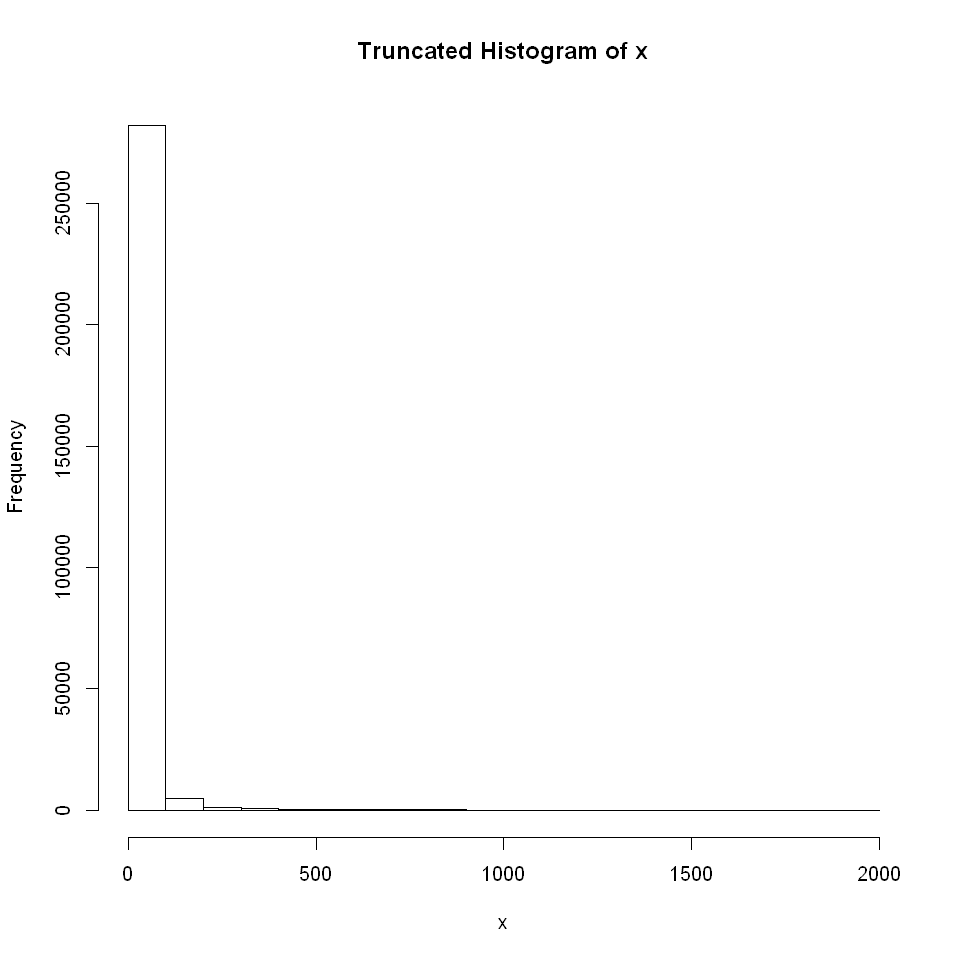

In [32]:
truncHist(d_test$interval_seconds,xmin = 0,xmax = 2000)

In [35]:
min(d_test$interval_seconds,na.rm = TRUE)

[1] -86388

In [43]:
d_test[d_test$interval_seconds < 0,c("interval_seconds")]

[1]     NA  -7932 -22448  -4215   -400  -6391 -11169 -78130  -8010  -1192
 [11] -66387  -9272 -83991  -6009 -58023 -68116 -67975   -257 -53762 -33447
 [21] -62078  -3147  -2104 -10452   -572  -5983  -1081 -41154 -66532  -4733
 [31] -59229 -56292   -526   -542 -47448 -19744  -2325 -86352 -49388 -39323
 [41]   -719 -73959 -28803   -780  -1827 -65616  -2350 -65451   -521 -62071
 [51] -77722 -35200 -64404 -85716  -1195   -465   -960 -45983 -11140 -21973
 [61] -60943 -64699 -46452 -21767   -669 -55474   -578 -86349 -17318 -63965
 [71] -64009    -82   -727   -397 -41830   -144 -61878 -18260 -18182 -12864
 [81]   -850   -923 -28392  -1026 -53134 -12889 -63272 -63172   -882 -63129
 [91] -10338 -59562  -1913   -401 -34070 -23777  -3137 -32565 -28166 -21319
[101] -61463 -61040 -53068 -32472 -61470   -442 -22130 -26296  -1535 -52780
[111]  -2951 -86178 -61001   -171 -42877  -4929 -60454 -13148 -59623 -59817
[121]   -910 -60030 -26439   -635 -28644  -8392  -4322 -45365 -43481  -1564
[131]  -1514   -358 -58499 -22075 -41384 -21552  -5689  -8911   -496  -1989
[141] -17834 -29394 -55079   -901    -18 -29611  -2994     -3 -56310 -26153
[151] -52439  -1076  -3433   -281 -31515 -54860 -31539    -41   -842  -2903
[161] -32878  -4024 -32290 -19682 -41027   -378 -83152 -86388  -1663  -2172
[171] -41187  -2000   -468   -698 -19574 -38083  -6893     -1 -38141  -2483
[181] -36736 -36680  -2908   -723 -13573 -37558 -42178 -48626  -4066   -870
[191] -34640 -32306  -2152  -2331 -22929  -5100 -42622 -31386  -1462  -2074
[201]   -320 -49609 -22062   -423 -34042 -30424  -1767  -1773   -185    -55
[211] -41157     -4  -1195  -1871  -1785    -86   -108 -28384 -85798  -8513
[221]  -1540  -2882  -1829  -1386   -574   -240 -36493  -5854    -37   -310
[231]    -64  -2426   -137  -5385  -1891  -8713   -534     -3  -4627 -18353
[241] -86303 -61402 -30713 -56702 -58251 -44680 -55584 -11454 -21686 -25522
[251] -56862   -481   -978  -3159  -1409  -2154 -22211   -144  -5623   -103
[261]  -1222  -7814 -81634  -2267 -60876    -98    -87 -60685  -1669  -1423
[271]  -5859  -3050   -321 -62384 -63140  -2807 -62950 -59688 -67196 -84916
[281] -61796  -1945 -63802 -62939 -70274 -17539    -48  -8156  -1922  -1990
[291]   -303 -21104    -11     -3  -1865  -2710   -516  -1758  -1588  -2053
[301]  -5563   -700  -1142  -9244  -1877  -3457     -8 -16721   -369   -264
[311]  -1594  -1612 -16235   -269   -205  -1577  -2460  -1104 -10854  -3875
[321]   -689 -12753   -955  -1844  -7750  -9555   -916  -1762  -1039  -1292
[331]   -255  -6150  -9984 -10096  -6824  -9341  -3650   -659  -1172  -1084
[341]  -4698  -1601   -286  -1797    -23  -1962  -3498  -5404  -3224  -1608
[351]  -3805  -3221   -107   -261  -2838   -902     -6   -591   -838   -414
[361] -61610 -41755  -3598 -78401 -69134 -27579 -70457    -33  -3017 -85858
[371]   -581 -80383  -4079  -2027   -960 -47904 -73797 -86376 -27008 -66703
[381] -76165  -3650  -2848 -27728 -61666 -72632 -69140  -6548 -11106 -86332
[391]  -4919  -4052 -55137 -75160  -2914  -2723 -86332 -86368  -1249 -71603
[401] -23011 -22480 -68531 -53773 -67485 -58284 -68204 -67670 -52998 -68885
[411] -19114 -12401 -21572 -17108 -52589 -50457 -11555 -67522 -13507 -57223
[421] -66432 -46568 -16413 -64629 -19475 -46849 -13758 -48976 -63731 -41790
[431] -12311 -14817 -54197  -3315 -24361 -28306 -38218 -36854 -32191 -18317
[441] -34356 -15408 -13799 -18648 -31499 -32609 -18309 -32961 -33006 -32172
[451]   -259 -28798 -15383   -990 -12920  -9943

### Day 1 10001 test

In [14]:
#df_test$dist_meters
filter = robreg.filter(df_test_computed$dist_meters, width=10,online=TRUE,method= "MED")

1 out of 255 time series values in df_test_computed$dist_meters are missing. 


In [40]:
d1$dist_meters = filter$level$MED

Warning message in as.POSIXlt.POSIXct(x):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXlt.POSIXct(x, tz):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXlt.POSIXct(x):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXlt.POSIXct(x, tz):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message:
"Removed 1 row(s) containing missing values (geom_path)."
Warning message in as.POSIXlt.POSIXct(x):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning 

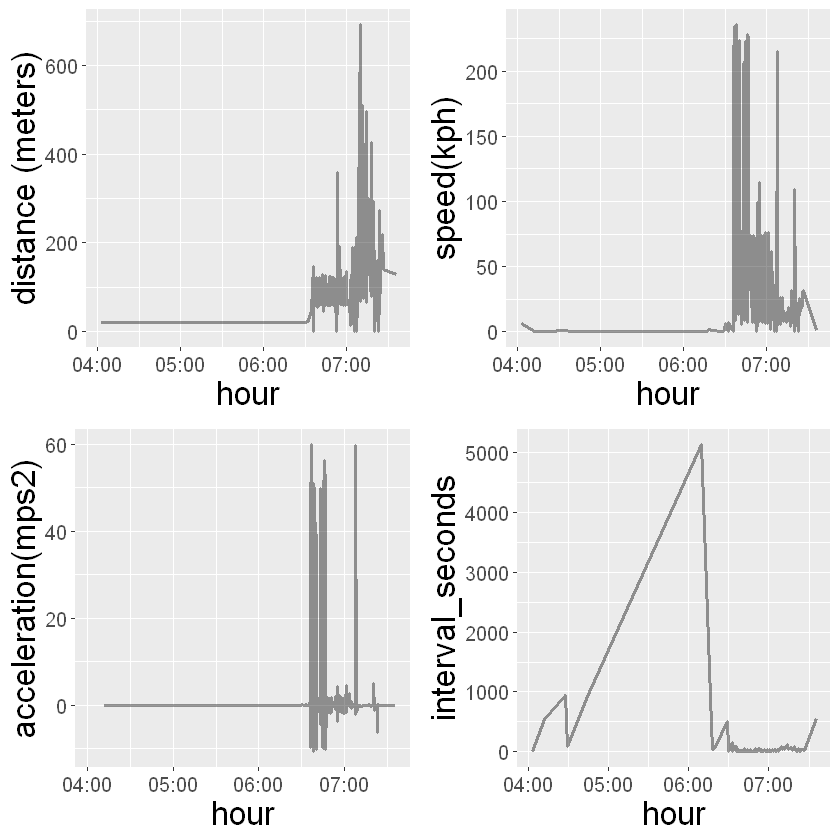

In [36]:
grid.arrange(p1, p2, p3, p4, ncol=2, nrow=2)

## Vehicle distance,speed, acceleration calculation 
### Spurious values statistics
### Value correction

In [18]:
# Function to compute distances (D), speeds (S) and acceleration (A) in meters, meters per second, km per hour and m s^-2
compute_speed_acceleration <- function(d) {
    d = data.frame(d)
#     d$dist_meters = NA
#     d$dist_meters = as.numeric(d$dist_meters)
#     d$interval_seconds = NA
#     d$interval_seconds = as.numeric(d$interval_seconds)
    d$speed_mps = NA
    d$speed_mps = as.numeric(d$speed_mps)
    d$speed_kph = NA
    d$speed_kph = as.numeric(d$speed_kph)
    d$accel_mps2 = NA
    d$accel_mps2 = as.numeric(d$accel_mps2)
    n <- nrow(d)
    diagnostics = {}
    if (n >= 2) {
#         # Compute interval distance using Haversine function
#         d$dist_meters[2:n] = distHaversine(cbind(d$lon[1:n-1],d$lat[1:n-1]),cbind(d$lon[2:n],d$lat[2:n]))
#         # Compute time interval
#         d$interval_seconds[2:n] = as.numeric(difftime(d$trxtime[2:n], d$trxtime[1:n-1], units = "secs"))
        # Compute speed in meters per second
        d$speed_mps[2:n] = d$dist_meters[2:n] / d$interval_seconds[2:n]
        # Convert speed to kph
        d$speed_kph[2:n] = d$speed_mps[2:n] * 3.6
        # # Compute accelerations
        # d$accel_mps2[2:n] = (d$speed_mps[2:n] - d$speed_mps[1:n-1])/d$interval_seconds[2:n]
        # Spurious values statistics
        index_excessive_speeds = as.numeric(row.names(d[(d$speed_kph > 128) & (!is.na(d$speed_kph)),]))
        # Original data metrics calculation
         diagnostics$mean_original_speed_kph = mean(as.numeric(d[, "speed_kph"]),na.rm=TRUE)
         diagnostics$min_original_speed_kph = min(as.numeric(d[, "speed_kph"]),na.rm=TRUE)
         diagnostics$max_original_speed_kph = max(as.numeric(d[, "speed_kph"]),na.rm=TRUE)
         diagnostics$num_original_speed_kph = length(as.numeric(d[, "speed_kph"]))
        # Excessive data metrics calculation
         diagnostics$mean_excess_speed_kph = mean(as.numeric(d[index_excessive_speeds, "speed_kph"]))
         diagnostics$min_excess_speed_kph = min(d[index_excessive_speeds, "speed_kph"]) 
         diagnostics$max_excess_speed_kph = max(as.numeric(d[index_excessive_speeds, "speed_kph"])) 
         diagnostics$num_excess_speed_kph = length(d[index_excessive_speeds, "speed_kph"]) 
         diagnostics$prop_excess_speed_kph = round(100*diagnostics$num_excess_speed/n, 2)
        # Correct the excessive speed values and recalculate acceleration and distance
        repeat{
        d[index_excessive_speeds, c('speed_kph',"speed_mps")] = d[index_excessive_speeds - 1 , c('speed_kph',"speed_mps")]
        d[index_excessive_speeds, "dist_meters"] = d[index_excessive_speeds, "speed_mps"] * d[index_excessive_speeds,"interval_seconds"]
        # d[index_excessive_speeds, "accel_mps2"] = (d[index_excessive_speeds, "speed_mps"] 
        #                                           - d[index_excessive_speeds - 1, "speed_mps"]) / d[index_excessive_speeds,"interval_seconds"]
        if(max(d$speed_kph,na.rm = TRUE) <= 128){break}
        }
         # Compute accelerations
         d$accel_mps2[2:n] = (d$speed_mps[2:n] - d$speed_mps[1:n-1])/d$interval_seconds[2:n]
        # Correct accelerations
         index_excessive_accelerations = as.numeric(row.names(d[(d$dist_meters == 0) & (d$accel_mps2 > 6),]))
         d[index_excessive_accelerations, "accel_mps2"] = d[index_excessive_accelerations - 1 , "accel_mps2"]
        # Corrected data metrics calculation
         diagnostics$mean_corrected_speed_kph = mean(as.numeric(d[, "speed_kph"]),na.rm=TRUE)
         diagnostics$min_corrected_speed_kph = min(as.numeric(d[, "speed_kph"]),na.rm=TRUE)
         diagnostics$max_corrected_speed_kph = max(as.numeric(d[, "speed_kph"]),na.rm=TRUE)
         diagnostics$num_corrected_speed_kph = length(as.numeric(d[, "speed_kph"]))
    }
    return(list(data = d ,diag_metrics = diagnostics))   
}

In [21]:
# Process calculation 
process_month_trajectory = function(data){
    results_df = data.frame() # empty dataframe
    diagnostics_df = data.frame()
    for(i in unique(data$day)) { 
        data_day <- data[data$day == i, ]
        # Put each train in one loop in a subset
        for (j in unique(data_day$trainid)) {
            data_day_train = data_day[data_day$trainid == j, ]        
            trajectory_and_diagnostics <- compute_trajectories(data_day_train)  
            trajectories = trajectory_and_diagnostics$data
            diagnostics = trajectory_and_diagnostics$diag_metrics          
            results_df <- rbind(results_df, trajectories)
            diagnostics_df <- rbind(diagnostics_df, diagnostics) 
        }
    }
     write.csv(x = results_df, file.path("../../data/tidy/", paste("trajectory", yy, mm, ".csv", sep = "-", collapse = "")))
    write.csv(x = diagnostics_df, file.path("../../data/tidy/", paste("trajectory-diagnostics" , yy, mm, ".csv", sep = "-",collapse = "")))
    # Uncomment the beneath line and check the computation result
    # return(list(result = results_df, result_diag = diagnostics_df ))
 }

In [ ]:
# Generate the final table
main = function(YEARLIST, MONTHLIST) {
    for (y in YEARLIST) {
        for (m in MONTHLIST) {
            df_agg = aggregate_line_trajectories(y, m)
            df_agg = preprocess_data(df_agg)
            process_month_trajectory(df_agg, y, m)            
        }
    }
}

In [ ]:
main(YEARLIST, MONTHLIST)

## something which will be used or not (this part wiil be deleted when this script has been done)

In [ ]:
# # aggregrate_trajectory_table
# aggregate_line_trajectories = function(year, month){
#     assign("dg", fread(paste(DISTANCE_FILEPATH, paste(paste(c("lightrail","trajectories",month, year),collapse = "-"),".csv",sep = ""), sep = "")))
#     assign("dh", fread(paste(DISTANCE_FILEPATH, paste(paste(c("heavyrail","trajectories",month, year),collapse = "-"),".csv",sep = ""), sep = "")))
#     # Combine the original tables to a single one for analysis
#     dg = subset(dg, select = c(trxtime, trainid, lineid, lat, lon))
#     dh = subset(dh, select = c(trxtime, trainid, lineid, lat, lon))
#     df = rbind(dg, dh)
#     return(df)
# }

In [ ]:
# aggregrate_trajectory_table
aggregate_line_trajectories = function(year, month){
    assign("dg", fread(paste(DISTANCE_FILEPATH, paste("lightrail", "trajectories", month, year, ".csv", sep = "-", collapse = ""), sep="")))
    assign("dh", fread(paste(DISTANCE_FILEPATH, paste("heavyrail", "trajectories", month, year, ".csv", sep = "-", collapse = ""), sep="")))
    # Combine the original tables to a single one for analysis
    dg = subset(dg, select = c(trxtime, trainid, lineid, lat, lon))
    dh = subset(dh, select = c(trxtime, trainid, lineid, lat, lon))
    df = rbind(dg, dh)
    return(df)
}

In [ ]:
# Fixed file path
assign("df", fread(paste(DISTANCE_FILEPATH, paste(DISTANCE_FILEPATH, paste("heavyrail", "trajectories", month, year, ".csv", sep = "-", collapse = ""), sep="")))

In [ ]:
add_dd_mm_yy_cols = function(df) {
    df$day = day(df$trxtime)
    df$month = month(df$trxtime)
    df$year = year(df$trxtime)
    return(df)
}
get_heavy_rail_trajectories = function(year, month){
    assign("df", fread(paste(DISTANCE_FILEPATH, paste(DISTANCE_FILEPATH, paste("heavyrail", "trajectories", month, year, ".csv", sep = "-", collapse = ""), sep="")))
    df = add_dd_mm_yy_cols(df)
    return(df)
}

get_light_rail_trajectories = function(year, month){
    assign("dg", fread(paste(DISTANCE_FILEPATH, paste("lightrail", "trajectories", month, year, ".csv", sep = "-", collapse = ""), sep="")))
    dg = add_dd_mm_yy_cols(dg)
    return(dg)
}